### Choose from configuration files

In [1]:
# "2dLink", "2dFall", "2dSwim", "2dThrow", "2dTplate", "2dFallingCircle"
# "3dHinge", "3dPrismatic", "3dCylindrical"

casename = "2dFall";

### Include Dyn3d and config files

In [2]:
include(Pkg.dir("Dyn3d")*"/src/Dyn3d.jl")
using Dyn3d
using Plots
pyplot()
using Interact, Reactive

In [3]:
include("../src/config_files/"*casename*".jl");

Config info set up.


### Build joint-body chain

In [4]:
bodys, joints, system = BuildChain(config_bodys, config_joints,
                                   config_system)
bd = BodyDyn(bodys, joints, system)

### Initialize system state

In [5]:
# init system
bd, soln = InitSystem!(bd)

# init soln structure
solns = (Soln)[]
push!(solns, soln)

# init VertsHistory struct
vs = []
push!(vs, VertsHistory(system.nbody, bd.bs));

This is a 8 body-joint system, system is fixed in space

### Set up HERKBody object

In [6]:
herk = HERKBody(system.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
                (HERKFuncf,HERKFuncgti), (UpdatePosition!,UpdateVelocity!))

Order-3 HERK time-marching function like object for Dyn3d


### Time Marching

#### Note that sometimes the solver can break due to singular matrix. Change between fixed step or not to solve the problem

In [7]:
idx = 0
@time begin
while soln.t < tf
    # advance one step
    soln, bd = herk(soln, bd)
#     soln, bd = herk(soln, bd, _isfixedstep=true)

    # record soln and verts_i info
    push!(solns, soln)
    push!(vs, VertsHistory(system.nbody, bd.bs))

    # print progress
    idx += 1
    if mod(idx,500) == 1
        @printf("itr = %d, t = %.3f, dt = %e\n", idx, soln.t, soln.dt)
#         println("center of mass at", MassCenter(bodys, system))
    end
end
@printf("itr = %d, t = %.3f, dt = %e\n", idx, soln.t, soln.dt)
end

itr = 1, t = 0.001, dt = 1.417527e-03
itr = 501, t = 1.172, dt = 1.335563e-03
itr = 1001, t = 1.955, dt = 1.940785e-03
itr = 1501, t = 3.003, dt = 2.286815e-03
itr = 2001, t = 4.178, dt = 8.527571e-04
itr = 2501, t = 4.736, dt = 2.794354e-03
itr = 3001, t = 5.321, dt = 8.493599e-04
itr = 3501, t = 6.155, dt = 1.440288e-03
itr = 4001, t = 6.682, dt = 1.248087e-03
itr = 4501, t = 7.307, dt = 7.987634e-04
itr = 5001, t = 7.726, dt = 1.347528e-03
itr = 5159, t = 8.001, dt = 2.063169e-03
 18.117280 seconds (26.27 M allocations: 6.103 GiB, 5.23% gc time)


### Save verts data on regulated time grid for movie in Matlab

#### 2d body is always constructed in z-x plane

In [8]:
bodys, joints, system = bd.bs, bd.js, bd.sys

using MAT
using Interpolations

# create regular time grid and acquire solutions on it
qJ_regs = Float64[]
t_reg = linspace(0,solns[end].t,length(solns))
for i = 1:system.ndof
    t_temp = ([solns[k].t for k = 1:length(solns)],)
    qJ_temp = [solns[k].qJ[i] for k = 1:length(solns)]   
    qJ_reg = interpolate(t_temp, qJ_temp, Gridded(Linear()))[t_reg]
    append!(qJ_regs, qJ_reg)
end
qJ_regs = reshape(qJ_regs,(length(solns), system.ndof))

# get verts info based on this regular grid solution
vs_reg = []
bodys_reg = deepcopy(bodys)
joints_reg = deepcopy(joints)
system_reg = deepcopy(system)
for i = 1:length(solns)
    bodys_reg, joints_reg, system_reg = UpdatePosition!(bodys_reg, joints_reg, system_reg, solns[i].qJ)
    push!(vs_reg, VertsHistory(system.nbody, bodys_reg))
end

# write to .mat file for animation
# vs_reg follow the form [ntime][nbody, nverts, xyz]
matwrite("../matlab_plot/verts_i.mat", Dict(
    "ndim" => system.ndim,
    "nbody" => system.nbody,
    "nverts" => bodys[1].nverts,
    "t" => collect(t_reg),
    "verts" => vs_reg
))

#### Store time-regulated verts in tuples

In [9]:
# plot direction
v = isdefined(:plot_dir) ? plot_dir : system.ndim==2 ? (1,2) : (1,2,3)

if system.ndim == 2
    # push the verts of all body in the same time into a tuple
    vs_total = []
    for i = 1:length(t_reg)
        vs_tmp = []
        for k = 1:system.nbody
            push!(vs_tmp,[vs_reg[i][k,:,v[1]],vs_reg[i][k,:,v[2]]])
        end
        push!(vs_total,vs_tmp)
    end
elseif system.ndim == 3
    h = [1:bodys[1].nverts;1]
    # push the verts of all body in the same time into a tuple
    vs_total = []
    for i = 1:length(t_reg)
        vs_tmp = []
        for k = 1:system.nbody
            push!(vs_tmp,[vs_reg[i][k,h,v[1]],vs_reg[i][k,h,v[2]],vs_reg[i][k,h,v[3]]])
        end
        push!(vs_total,vs_tmp)
    end       
end

### Interactive plot

In [10]:
# total number of frames for this interactive plot
plot_number = 50

50

Interact.Options{:SelectionSlider,Any}(1: "input" = 2576 Any , "i", 2576, "2576", 26, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"104"=>104,"207"=>207,"310"=>310,"413"=>413,"516"=>516,"619"=>619,"722"=>722,"825"=>825,"928"=>928…), Dict{Any,Any}(Pair{Any,Any}(2473, "2473"),Pair{Any,Any}(3194, "3194"),Pair{Any,Any}(2782, "2782"),Pair{Any,Any}(1237, "1237"),Pair{Any,Any}(4430, "4430"),Pair{Any,Any}(3503, "3503"),Pair{Any,Any}(4327, "4327"),Pair{Any,Any}(4224, "4224"),Pair{Any,Any}(207, "207"),Pair{Any,Any}(3709, "3709")…)), Any[], Any[], true, "horizontal")

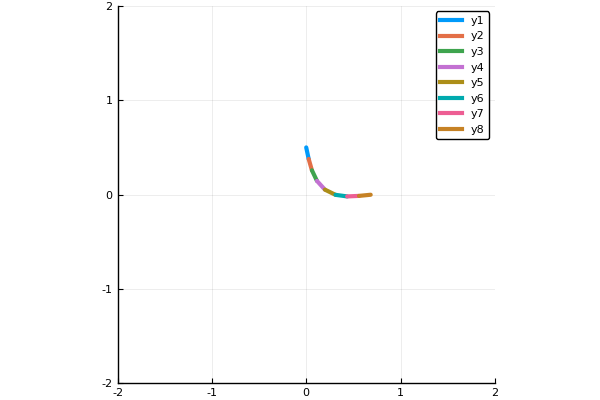

In [11]:
freq = round(Int,idx/plot_number)
camera_view = (45,45)

if system.ndim == 2
    @manipulate for i = 1:freq:length(t_reg)
        p = plot()        
        for j in 1:system.nbody
            plot!(vs_total[i][j][1],vs_total[i][j][2], linewidth=3)            
        end    
        plot!(xlims=(-2,2), ylims=(-2,2), aspect_ratio=:equal)        
    end
elseif system.ndim == 3
    @manipulate for i = 1:freq:length(t_reg)
        h = [1:bodys[1].nverts;1]
        p = plot()
        for j in 2:system.nbody
            plot!(vs_total[i][j][1],vs_total[i][j][2],vs_total[i][j][3], linewidth=3)
        end    
        plot!(xlims=(-2,2), ylims=(-2,2), zlims=(-2,2), aspect_ratio=:equal, camera = camera_view)     
    end
end

### Make gif

In [14]:
# Total number of seconds of this gif
gif_time = 4

4

In [15]:
freq = round(Int,idx/30/gif_time)
camera_view = (45,45)

if system.ndim == 2
    anim = @animate for i = 1:freq:length(t_reg)
        p = plot()        
        for j in 1:system.nbody
            plot!(vs_total[i][j][1],vs_total[i][j][2], linewidth=3)            
        end    
        plot!(xlims=(-2,2), ylims=(-2,2), aspect_ratio=:equal)        
    end        
elseif system.ndim == 3 
    anim = @animate for i = 1:freq:length(t_reg)
        h = [1:bodys[1].nverts;1]
        p = plot()
        for j in 2:system.nbody
            plot!(vs_total[i][j][1],vs_total[i][j][2],vs_total[i][j][3], linewidth=3)
        end    
        plot!(xlims=(-2,2), ylims=(-2,2), zlims=(-2,2), aspect_ratio=:equal, camera = camera_view)
    end    
end

gif(anim, casename*".gif", fps = 30)

INFO: Saved animation to /media/ruizhi/Seagate Expansion Drive/Research/Dyn3d.jl/notebook/2dFall.gif


Plots.AnimatedGif("/media/ruizhi/Seagate Expansion Drive/Research/Dyn3d.jl/notebook/2dFall.gif")